In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, brier_score_loss
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib
import shap

np.random.seed(42)
sns.set(style='whitegrid')


c:\Users\dario\anaconda3\envs\jupyter_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = pd.read_csv('scoring_sintetico.csv', parse_dates=['fecha_solicitud'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cliente_id                  20000 non-null  int64         
 1   fecha_solicitud             20000 non-null  datetime64[ns]
 2   edad                        20000 non-null  int64         
 3   ingreso_mensual             20000 non-null  float64       
 4   estado_laboral              20000 non-null  object        
 5   cant_dependientes           20000 non-null  int64         
 6   meses_historial_crediticio  20000 non-null  int64         
 7   defaults_previos            20000 non-null  int64         
 8   saldo_promedio_mensual      19000 non-null  float64       
 9   cant_prestamos_activos      20000 non-null  int64         
 10  ult_demora_pago_dias        20000 non-null  int64         
 11  pagos_a_tiempo_6m           20000 non-null  int64     

In [12]:
df.head()

,cliente_id,fecha_solicitud,edad,ingreso_mensual,estado_laboral,cant_dependientes,meses_historial_crediticio,defaults_previos,saldo_promedio_mensual,cant_prestamos_activos,ult_demora_pago_dias,pagos_a_tiempo_6m,monto_solicitado,monto_aprobado,default_90d
0,9743,2018-01-01,54,165807.25,empleado,0,85,0,13406.12,0,3,3,22163.60,9064.30,0
1,12235,2018-01-01,39,84304.37,desempleado,2,93,0,2277.75,2,0,1,83543.76,NaN,0
2,15410,2018-01-01,42,39914.79,empleado,2,18,0,5151.95,1,6,0,137573.10,82475.16,0
3,2888,2018-01-01,23,86945.44,empleado,1,7,0,22804.65,1,7,0,59754.37,46176.79,0
4,18825,2018-01-01,52,36006.29,empleado,0,23,0,4599.77,2,5,6,148163.59,86199.31,1


In [13]:
print('Valores faltantes (%):') 
print((df.isna().mean()*100).round(2).sort_values(ascending=False))

Valores faltantes (%):
monto_aprobado                22.43
saldo_promedio_mensual         5.00
cliente_id                     0.00
ingreso_mensual                0.00
estado_laboral                 0.00
fecha_solicitud                0.00
edad                           0.00
meses_historial_crediticio     0.00
cant_dependientes              0.00
cant_prestamos_activos         0.00
defaults_previos               0.00
ult_demora_pago_dias           0.00
pagos_a_tiempo_6m              0.00
monto_solicitado               0.00
default_90d                    0.00
dtype: float64


In [18]:
print(df['default_90d'].value_counts(normalize=True).round(3))

default_90d
0    0.933
1    0.067
Name: proportion, dtype: float64


In [ ]:
df['ratio_deuda_ingreso'] = df['monto_solicitado'] / (df['ingreso_mensual'] * 12)


0         1.113924
1         8.258148
2        28.722248
3         5.727190
4        34.291136
           ...    
19995     3.195758
19996    50.000735
19997     4.189658
19998    17.435277
19999    30.177941
Name: ratio_deuda_ingreso, Length: 20000, dtype: float64

<Axes: xlabel='ratio_deuda_ingreso', ylabel='Count'>

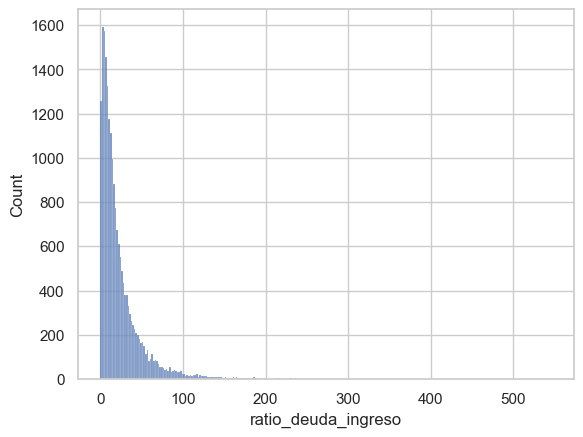

In [25]:
df['ratio_deuda_ingreso'].describe() 
sns.histplot((df['ratio_deuda_ingreso']*100))

In [ ]:
df['flag_historial_riesgo'] = (df['defaults_previos'] > 0).astype(int)
df['flag_historial_riesgo'].value_counts()

flag_historial_riesgo
False    18395
True      1605
Name: count, dtype: int64

In [30]:
df['defaults_previos'].value_counts()

defaults_previos
0    18395
1     1605
Name: count, dtype: int64